In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import joblib


In [24]:

# Load training data
train_data = pd.read_csv('../main_dataset.csv')

train_low = train_data[train_data['Id'] <= 1e-15]
train_low["Log_Id"] =  np.log10(train_low['Id'])

train_high = train_data[train_data['Id'] > 1e-15]
train_high["Log_Id"] =  np.log10(train_high['Id'])



C:\Users\studi\AppData\Local\Temp\ipykernel_11180\1352617479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_low["Log_Id"] =  np.log10(train_low['Id'])
C:\Users\studi\AppData\Local\Temp\ipykernel_11180\1352617479.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_high["Log_Id"] =  np.log10(train_high['Id'])


In [25]:

# Prepare features and target for low current model
X_low = train_low[['Tox','Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]
y_low = train_low['Log_Id']

# Prepare features and target for high current model
X_high = train_high[['Tox', 'Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]
y_high = train_high['Log_Id']

# Polynomial and scaling transformation


scaler_low = StandardScaler()
scaler_high = StandardScaler()

X_low_scaled = scaler_low.fit_transform(X_low)

# Transform and scale for high current model

X_high_scaled = scaler_high.fit_transform(X_high)  # Reuse the fitted scaler

# # Train the XGBoost models
model_low = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1)
model_high = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1)

model_low.fit(X_low_scaled, y_low)
model_high.fit(X_high_scaled, y_high)

# # Save the trained models
# joblib.dump(model_low, 'xgboost_model_low.joblib')
# joblib.dump(model_high, 'xgboost_model_high.joblib')


# model_low = joblib.load('xgboost_model_low.joblib')
# model_high = joblib.load('xgboost_model_high.joblib')




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

407    5.590000e-18
408    7.050000e-16
409    5.650000e-18
410    5.400000e-18
411    5.370000e-18
           ...     
598    7.460000e-18
599    7.500000e-18
600    7.330000e-18
601    7.390000e-18
602    7.390000e-18
Name: Id, Length: 196, dtype: float64
[7.00671244e-15 1.66919288e-15 1.58864873e-15 1.91640336e-15
 3.40772091e-15 3.48655511e-15 3.62989913e-15 3.94608679e-15
 4.47694648e-15 5.22385209e-15 6.20720779e-15 6.73439474e-15
 8.07039270e-15 8.76092022e-15 7.33820895e-15 6.62030533e-15
 4.76312249e-15 3.88313827e-15 3.84232229e-15 3.74735423e-15
 4.09260189e-15 3.91954798e-15 3.74655590e-15 4.78048497e-15
 5.28594468e-15 5.44823281e-15 4.81109928e-15 5.06862610e-15
 5.53390257e-15 5.79029944e-15 6.63729258e-15 7.38016080e-15
 8.04184007e-15 8.13258694e-15 7.07136943e-15 7.10619138e-15
 7.14735041e-15 7.12265770e-15 1.96366738e-15 2.05982065e-15
 2.01797341e-15 1.88233252e-15 1.97508856e-15 2.40387463e-15
 2.79744235e-15 3.05801277e-15 3.40052240e-15 3.63284977e-15
 4.1912727

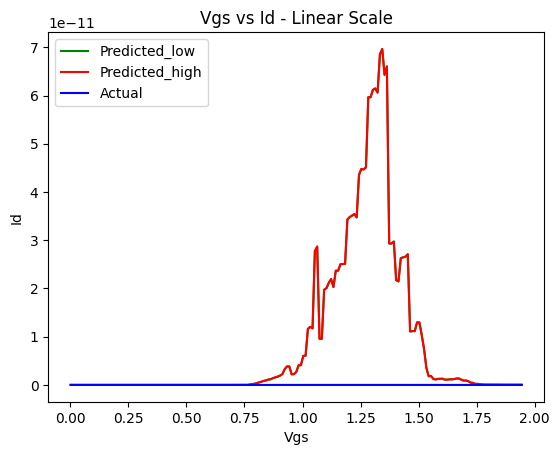

-------------


In [26]:

# Load test data


from sklearn.metrics import mean_absolute_error

test_dataset = pd.read_csv('../main_dataset.csv').iloc[407:603]

test_features = test_dataset[['Tox','Nc', 'Nd', 'Ns', 'Vds', 'Vgs']]

def predict_current(test_features):
    
    # # Prepare data for Model 1 (low current values)
    # row_low = scaler_low.transform(poly_low.transform([row]))
    # pred_low = model_low.predict(row_low)[0]
    
    x_low = scaler_low.transform(test_features)
    x_high = scaler_high.transform(test_features)

    predict_low_log = model_low.predict(x_low)
    predict_high_log = model_high.predict(x_high)

    predict_high = np.power(10, predict_high_log)  
    predict_low = np.power(10, predict_low_log)

    predict_high = np.where(predict_high < 1e-15, 0, predict_high)

    predict_low = np.where(predict_low > 1e-15, 0, predict_low )
    

    predictions = np.where(predict_high ==0, predict_low, predict_high )
    print(predictions)
    return predictions

print(test_dataset['Id'])
predictions = predict_current(test_features)
print(r2_score(predictions, test_dataset['Id']))
# # Evaluation
# print("R² Score low:", r2_score(test_dataset['Id'], predictions[0] ))
# print("mae -1  low_model  : " , mean_absolute_error(test_dataset['Id'], predictions[0] ))
# print("R² Score  high :", r2_score(test_dataset['Id'], predictions[1] ))

# print("mae -2  high_model : ", mean_absolute_error(test_dataset['Id'], predictions[1] ))



# Plotting
plt.plot(test_features['Vgs'], predictions, color="green", label="Predicted_low")
plt.plot(test_features['Vgs'], predictions, color="red", label="Predicted_high")

plt.plot(test_features['Vgs'], test_dataset['Id'], color="blue", label="Actual", )
plt.title('Vgs vs Id - Linear Scale')
plt.xlabel('Vgs')
plt.ylabel('Id')
# plt.ylim(0, 1e-15)
plt.legend()
plt.show()

print("-------------")


In [27]:
np.arange(10, 32, 5)

array([10, 15, 20, 25, 30])